In [1]:
import os
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection as skl
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

import seaborn as sns

In [10]:
# Read data
DATA_DIR = os.path.expanduser('~/workspace/data/UCI')
df = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))

In [11]:
df['y']

0        4
1        1
2        5
3        5
4        5
        ..
11495    2
11496    1
11497    5
11498    3
11499    4
Name: y, Length: 11500, dtype: int64

In [13]:
# Set seizure activity label with 1 and the others with zero
# Info about initial class labels: https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition
df.loc[df.y != 1, 'y'] = 0

In [14]:
df['y']

0        0
1        1
2        0
3        0
4        0
        ..
11495    0
11496    1
11497    0
11498    0
11499    0
Name: y, Length: 11500, dtype: int64

In [39]:
# Train/test split, 1/11 is used here since we are using 2/5 of training sample for training
train_df, test_df = skl.train_test_split(df, test_size = 1 / 11, stratify = df['y'])

In [40]:
print('original: {}, train: {}, test: {}'.format(df.shape, train_df.shape, test_df.shape))

original: (11500, 180), train: (10454, 180), test: (1046, 180)


In [41]:
# Report positive labels distribution
print('Positive label percentage in train set', train_df['y'].sum()/len(train_df))
print('Positive label percentage in test set', test_df['y'].sum()/len(test_df))

Positive label percentage in train set 0.20001913143294434
Positive label percentage in test set 0.19980879541108987


In [42]:
# make equal number of positive and negative smaples in training
pos_indexes = train_df[train_df.y==1].index.tolist()
neg_indexes = train_df[train_df.y==0].index.tolist()
neg_samples = sample(neg_indexes, len(pos_indexes))
print(len(pos_indexes), len(neg_indexes), len(neg_samples))

2091 8363 2091


In [43]:
train_df = train_df.loc[pos_indexes + neg_samples]
print(train_df.shape)

(4182, 180)


In [44]:
# Percentage of positive labels in the training
print('Positive label percentage in train set', train_df['y'].sum()/len(train_df))

Positive label percentage in train set 0.5


In [45]:
# Associated features
x_train, y_train, x_test, y_test = train_df.drop(['y','Unnamed: 0'], axis=1), train_df['y'], test_df.drop(['y','Unnamed: 0'], axis=1), test_df['y']
print('train_df: {}, x_train: {}, y_train: {}, x_test: {}, y_test: {}'.format(train_df.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape))

train_df: (4182, 180), x_train: (4182, 178), y_train: (4182,), x_test: (1046, 178), y_test: (1046,)


In [51]:
print(x_train)

X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X169  X170  \
8226  -167 -138  -68   -7   32   42   57   61   46    6  ...   -96   -49   
2621   296  165   52  -37 -110 -174 -221 -252 -268 -276  ...  -356  -342   
1614   360  487  519  503  511  550  615  710  810  923  ...   454   318   
11169 -384 -321 -168   43  268  458  571  613  604  552  ...    61    24   
10376  -68  -64  -80  -40    8   20   12  -28  -47  -60  ...   119   174   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
7506    20   16    9   16   24   26    1  -26  -55  -80  ...    -5   -19   
5735   -30  -40  -47  -45  -38  -30  -30  -23  -22  -27  ...    16     8   
2609   -27  -19  -35  -55  -57  -64  -46  -26  -45  -44  ...   -42   -62   
6884   -32  -33  -31  -39  -52  -54  -60  -64  -70  -73  ...   -99   -96   
8152   -48  -62  -72  -80  -79  -67  -42   -1   27   28  ...  -128  -128   

       X171  X172  X173  X174  X175  X176  X177  X178  
8226    -44   -44  -125  -219  -265  -2

[[1.         0.94458949 0.79530786 ... 0.03003702 0.024163   0.0236119 ]
 [0.94458949 1.         0.94092864 ... 0.02067738 0.02006908 0.02161405]
 [0.79530786 0.94092864 1.         ... 0.01296675 0.01463047 0.0152615 ]
 ...
 [0.03003702 0.02067738 0.01296675 ... 1.         0.92423873 0.74013083]
 [0.024163   0.02006908 0.01463047 ... 0.92423873 1.         0.93136778]
 [0.0236119  0.02161405 0.0152615  ... 0.74013083 0.93136778 1.        ]]


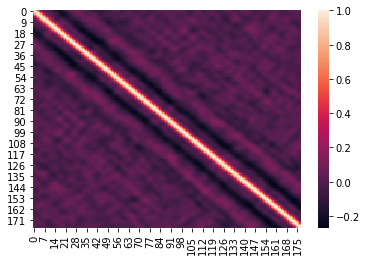

In [50]:
corcof = np.corrcoef(np.transpose(x_train))
print(corcof)
ax = sns.heatmap(corcof, annot=False)
plt.show()

In [52]:
# Scaling features
# sc = StandardScaler()
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [56]:
# unified sets
train = np.concatenate((x_train, y_train[:,None]), axis=1)
test = np.concatenate((x_test, y_test[:,None]), axis=1)

# Save the processed data
pd.DataFrame(train).to_csv(os.path.join(DATA_DIR,'train.csv'))
pd.DataFrame(test).to_csv(os.path.join(DATA_DIR,'test.csv'))

In [57]:
###############################
######## Classifier ###########
###############################

# Supervised transformation based on random forests
# Good to know about feature transformation
n_estimator=10
# cls = RandomForestClassifier(max_depth=5, n_estimators=n_estimator)
cls = GradientBoostingClassifier(n_estimators=n_estimator)
cls.fit(x_train, y_train)
y_pred_rf = cls.predict_proba(x_test)[:, 1]

# ROC
fpr_rf_lm, tpr_rf_lm, _ = metrics.roc_curve(y_test, y_pred_rf)
print('AUROC: ', metrics.auc(fpr_rf_lm,tpr_rf_lm))

# PR
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_rf)
AUPRC = metrics.auc(recall, precision)
print('AP: ', metrics.average_precision_score(y_test, y_pred_rf))
print('Area under the precision recall curve: ', AUPRC)

AUROC:  0.9742901568028902
AP:  0.9165488937102201
Area under the precision recall curve:  0.917165958069953
